In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import sklearn
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from dltime.models.FCN import FCN
from tqdm import tqdm
%matplotlib inline

In [3]:
data_for_train = ['zwy', 'zwy2', 'zwy3', 'zwy4', 'zwy5', 'j11', 'j11_2', 'j11_md', 'j11_527', 'yqcc', 'yqcc2', 'syf', 'syf2', 'sky', 'sky2', 'sky3', 'zyq', 'zyq2']
param_dict = {}
for data_name in tqdm(data_for_train):
    param_dict[data_name] = []
    named_params = torch.load(f"./outputs/{data_name}_FCN.pth")
    for n, p in named_params.items():
        if 'conv1d.weight' in n:
            param_dict[data_name].append(p.detach().clone().cpu().numpy())


100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


(1, 384)


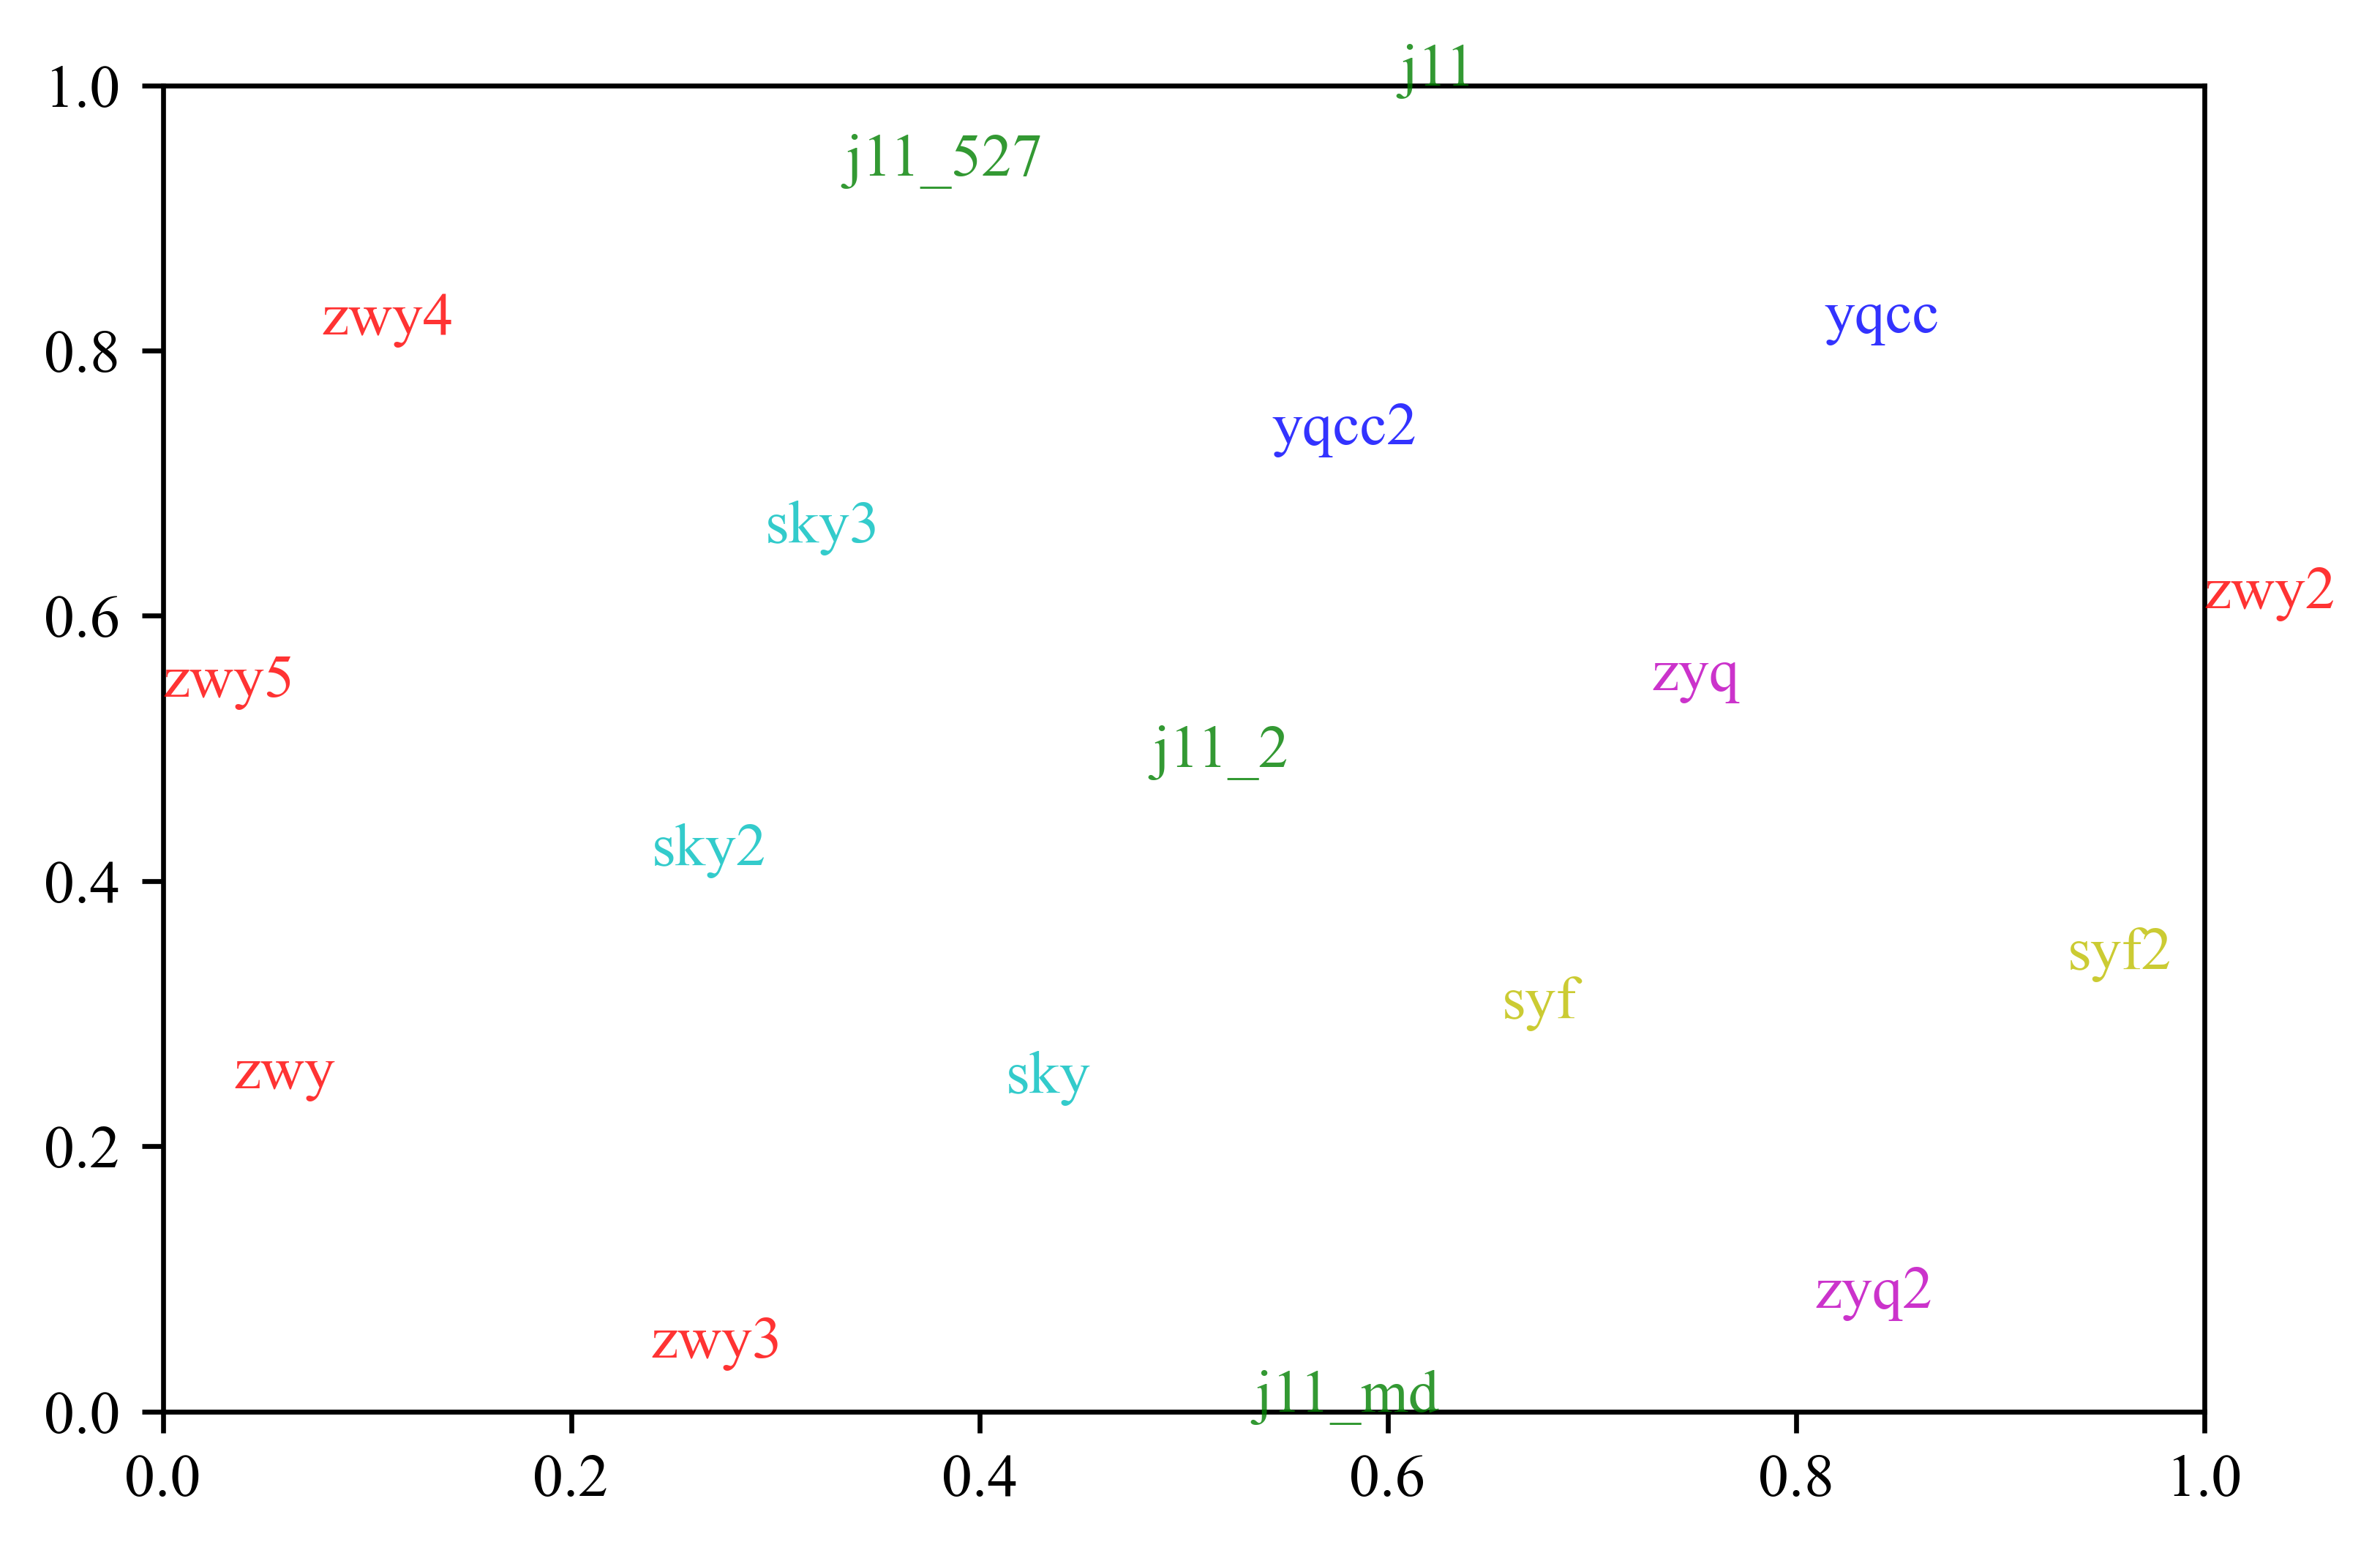

In [4]:
all_data = []
for value in param_dict.values():
    all_data.append(value[2].mean(axis=0).reshape(1, -1))
print(all_data[0].shape)
all_data = np.concatenate(all_data, axis=0)
X = MinMaxScaler().fit_transform(all_data)
X_embed = TSNE(n_components=2).fit_transform(all_data)
X_embed = MinMaxScaler().fit_transform(X_embed)

plt.figure(dpi=600)
plt.rc('font',family='Times New Roman')
colors = ['r'] * 5 + ['g'] * 4 + ['b'] * 2 + ['y'] * 2 + ['c'] * 3 + ['m'] * 2
for idx, key in enumerate(param_dict.keys()):
    plt.text(X_embed[idx, 0], X_embed[idx, 1], key, color=colors[idx], alpha = 0.8)
# plt.scatter(X_embed[18:24, 0], X_embed[18:24, 1], c='g', alpha = 0.2, label = "xcxp")
# plt.scatter(X_embed[22:24, 0], X_embed[22:24, 1], c='g', alpha = 0.2)
# plt.legend()
plt.show()

In [3]:
from dltime.models.InceptionTime import InceptionBlock
from dltime.data.ts_datasets import Soil_Dataset
from utils import load_pkl
from data_process import handle_dataset_3dims
import torch.nn as nn
from torch.utils.data import DataLoader

In [4]:
class InceptionTimeRep(nn.Module):
    "InceptionTime"

    def __init__(self, c_in, c_out, nf=32):
        super().__init__()
        self.inceptionblock1 = InceptionBlock(c_in, nf)
        self.inceptionblock2 = InceptionBlock(nf*4, nf)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(nf * 4, c_out)

    def forward(self, x):
        x = self.inceptionblock1(x)
        x = self.inceptionblock2(x)
        x = self.gap(x).squeeze(-1)
        return x

In [5]:
def infer_fn(valid_loader, model, device):
    model.eval()
    preds = []
    for step, item in enumerate(valid_loader):
        for k, v in item.items():
            item[k] = v.to(device)

        labels = item['label']
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(item['input'])

        preds.append(y_preds.detach().cpu().numpy())
        
    predictions = np.concatenate(preds)
    return predictions

In [23]:
# data_for_train = ['zwy', 'zwy2', 'zwy3', 'zwy4', 'zwy5', 'j11', 'j11_2', 'j11_md', 'j11_527', 'yqcc', 'yqcc2', 'syf', 'syf2', 'sky', 'sky2', 'sky3', 'zyq', 'zyq2']
data_for_train = ['sky2']
# data_for_train = ['sky2', 'zwy2', 'zwy3', 'zwy4', 'zwy5']
rep_dict = {}
label_dict = {}
model = InceptionTimeRep(c_in=5, c_out=3).to('cuda')
model.load_state_dict(torch.load('.\outputs\zwy_2022-08-03 01.26.pth'))
# train_data, test_data = [], []
for data_name in tqdm(data_for_train):
    train_data = load_pkl(f'./pickle_data/{data_name}_train_64.pkl')
    test_data = load_pkl(f'./pickle_data/{data_name}_test_64.pkl')
    total_data = train_data + test_data
    total_x, total_label = handle_dataset_3dims(train_data, mode="all")
    total_x = np.swapaxes(total_x, 2, 1)
    total_dataset = Soil_Dataset(total_x, total_label, normalize=None, channel_first=True)
    total_dataloader = DataLoader(total_dataset, batch_size=16, shuffle=False, drop_last=False)

    label_dict[data_name] = total_label[:] 
    pred = infer_fn(total_dataloader, model, 'cuda')
    rep_dict[data_name] = pred[:]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


In [24]:
all_data = np.concatenate(list(rep_dict.values()), axis=0)
X = MinMaxScaler().fit_transform(all_data)
X_embed = TSNE(n_components=2).fit_transform(all_data)
X_embed = MinMaxScaler().fit_transform(X_embed)
print(X_embed.shape)

(1459, 2)


In [25]:
all_label = np.concatenate(list(label_dict.values()), axis=0)
dig_idx, jump_idx, walk_idx = [], [], []
for idx in range(X_embed.shape[0]):
    if all_label[idx] == 0:
        dig_idx.append(idx)
    elif all_label[idx] == 1:
        jump_idx.append(idx)
    else:
        walk_idx.append(idx)

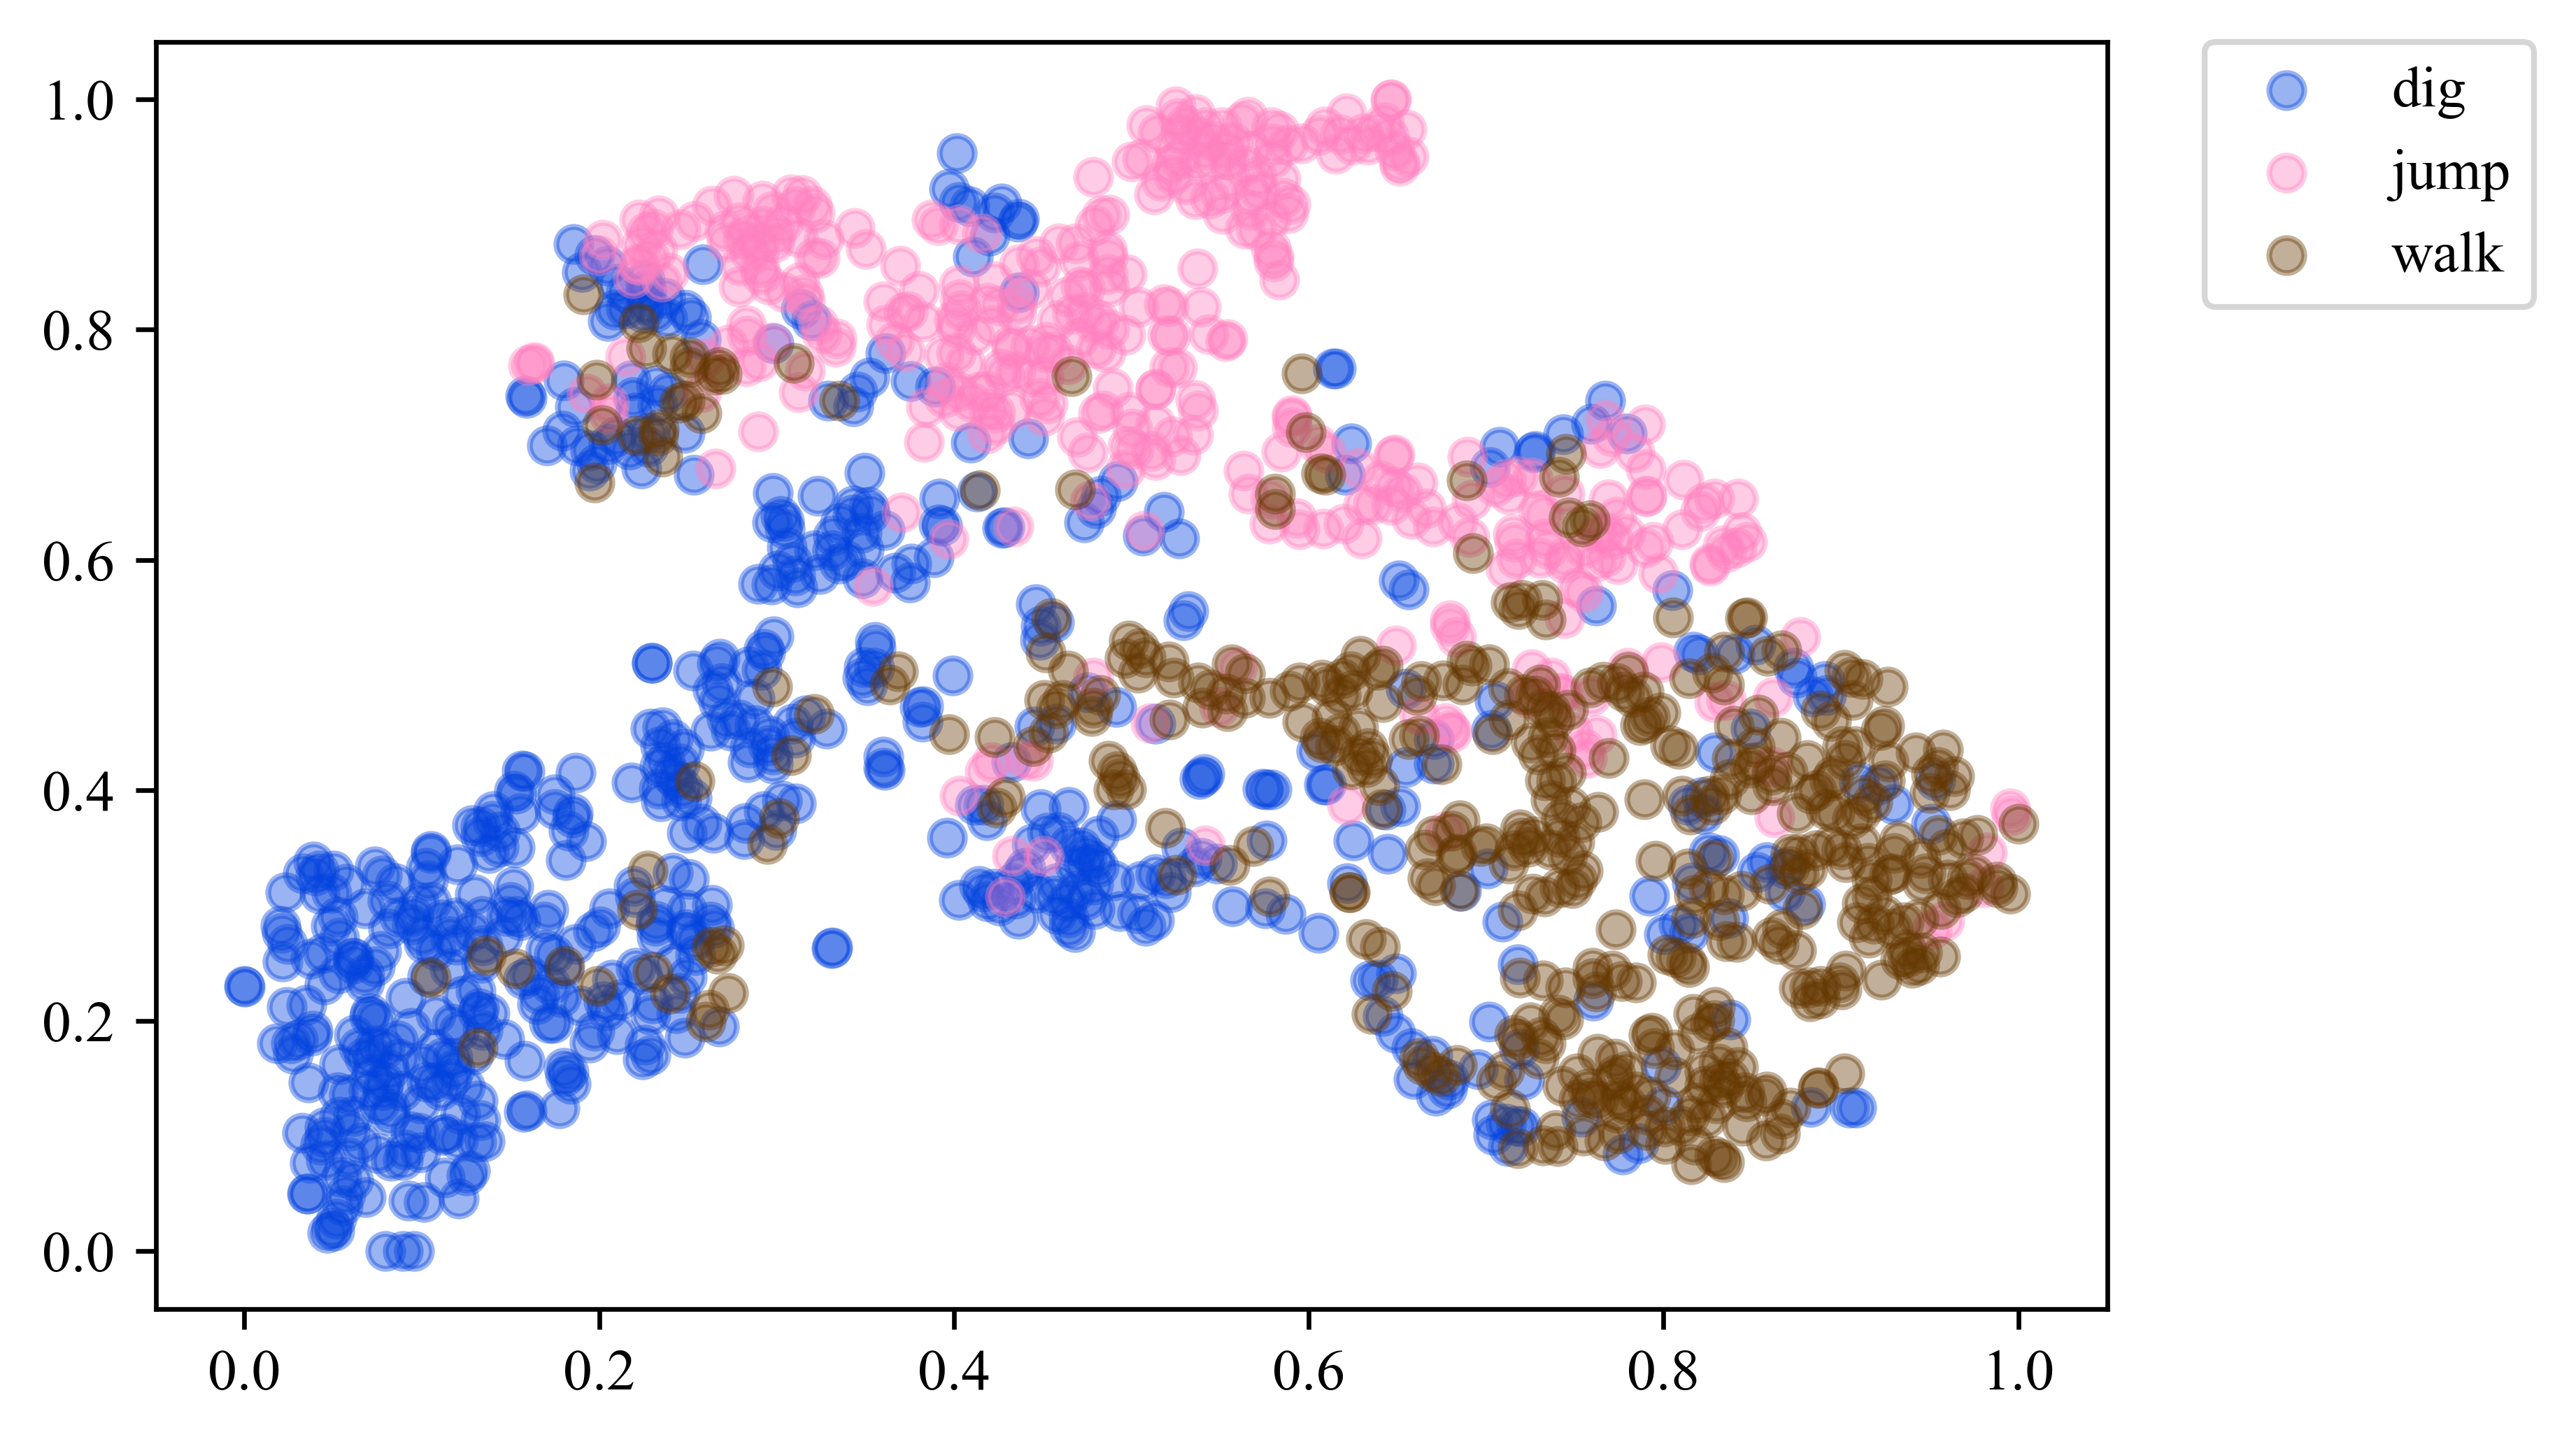

In [26]:
plt.figure(dpi=600)
plt.rc('font',family='Times New Roman')
# colors = ['r'] * 5 + ['g'] * 4 + ['b'] * 2 + ['y'] * 2 + ['c'] * 3 + ['m'] * 2
colors = ['#0343df', '#ff81c0', '#653700']

plt.scatter(X_embed[dig_idx, 0], X_embed[dig_idx, 1], c=colors[0], alpha = 0.4, label='dig')
plt.scatter(X_embed[jump_idx, 0], X_embed[jump_idx, 1], c=colors[1], alpha = 0.4, label='jump')
plt.scatter(X_embed[walk_idx, 0], X_embed[walk_idx, 1], c=colors[2], alpha = 0.4, label='walk')
# plt.scatter(X_embed[18:24, 0], X_embed[18:24, 1], c='g', alpha = 0.2, label = "xcxp")
# plt.scatter(X_embed[22:24, 0], X_embed[22:24, 1], c='g', alpha = 0.2)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.show()

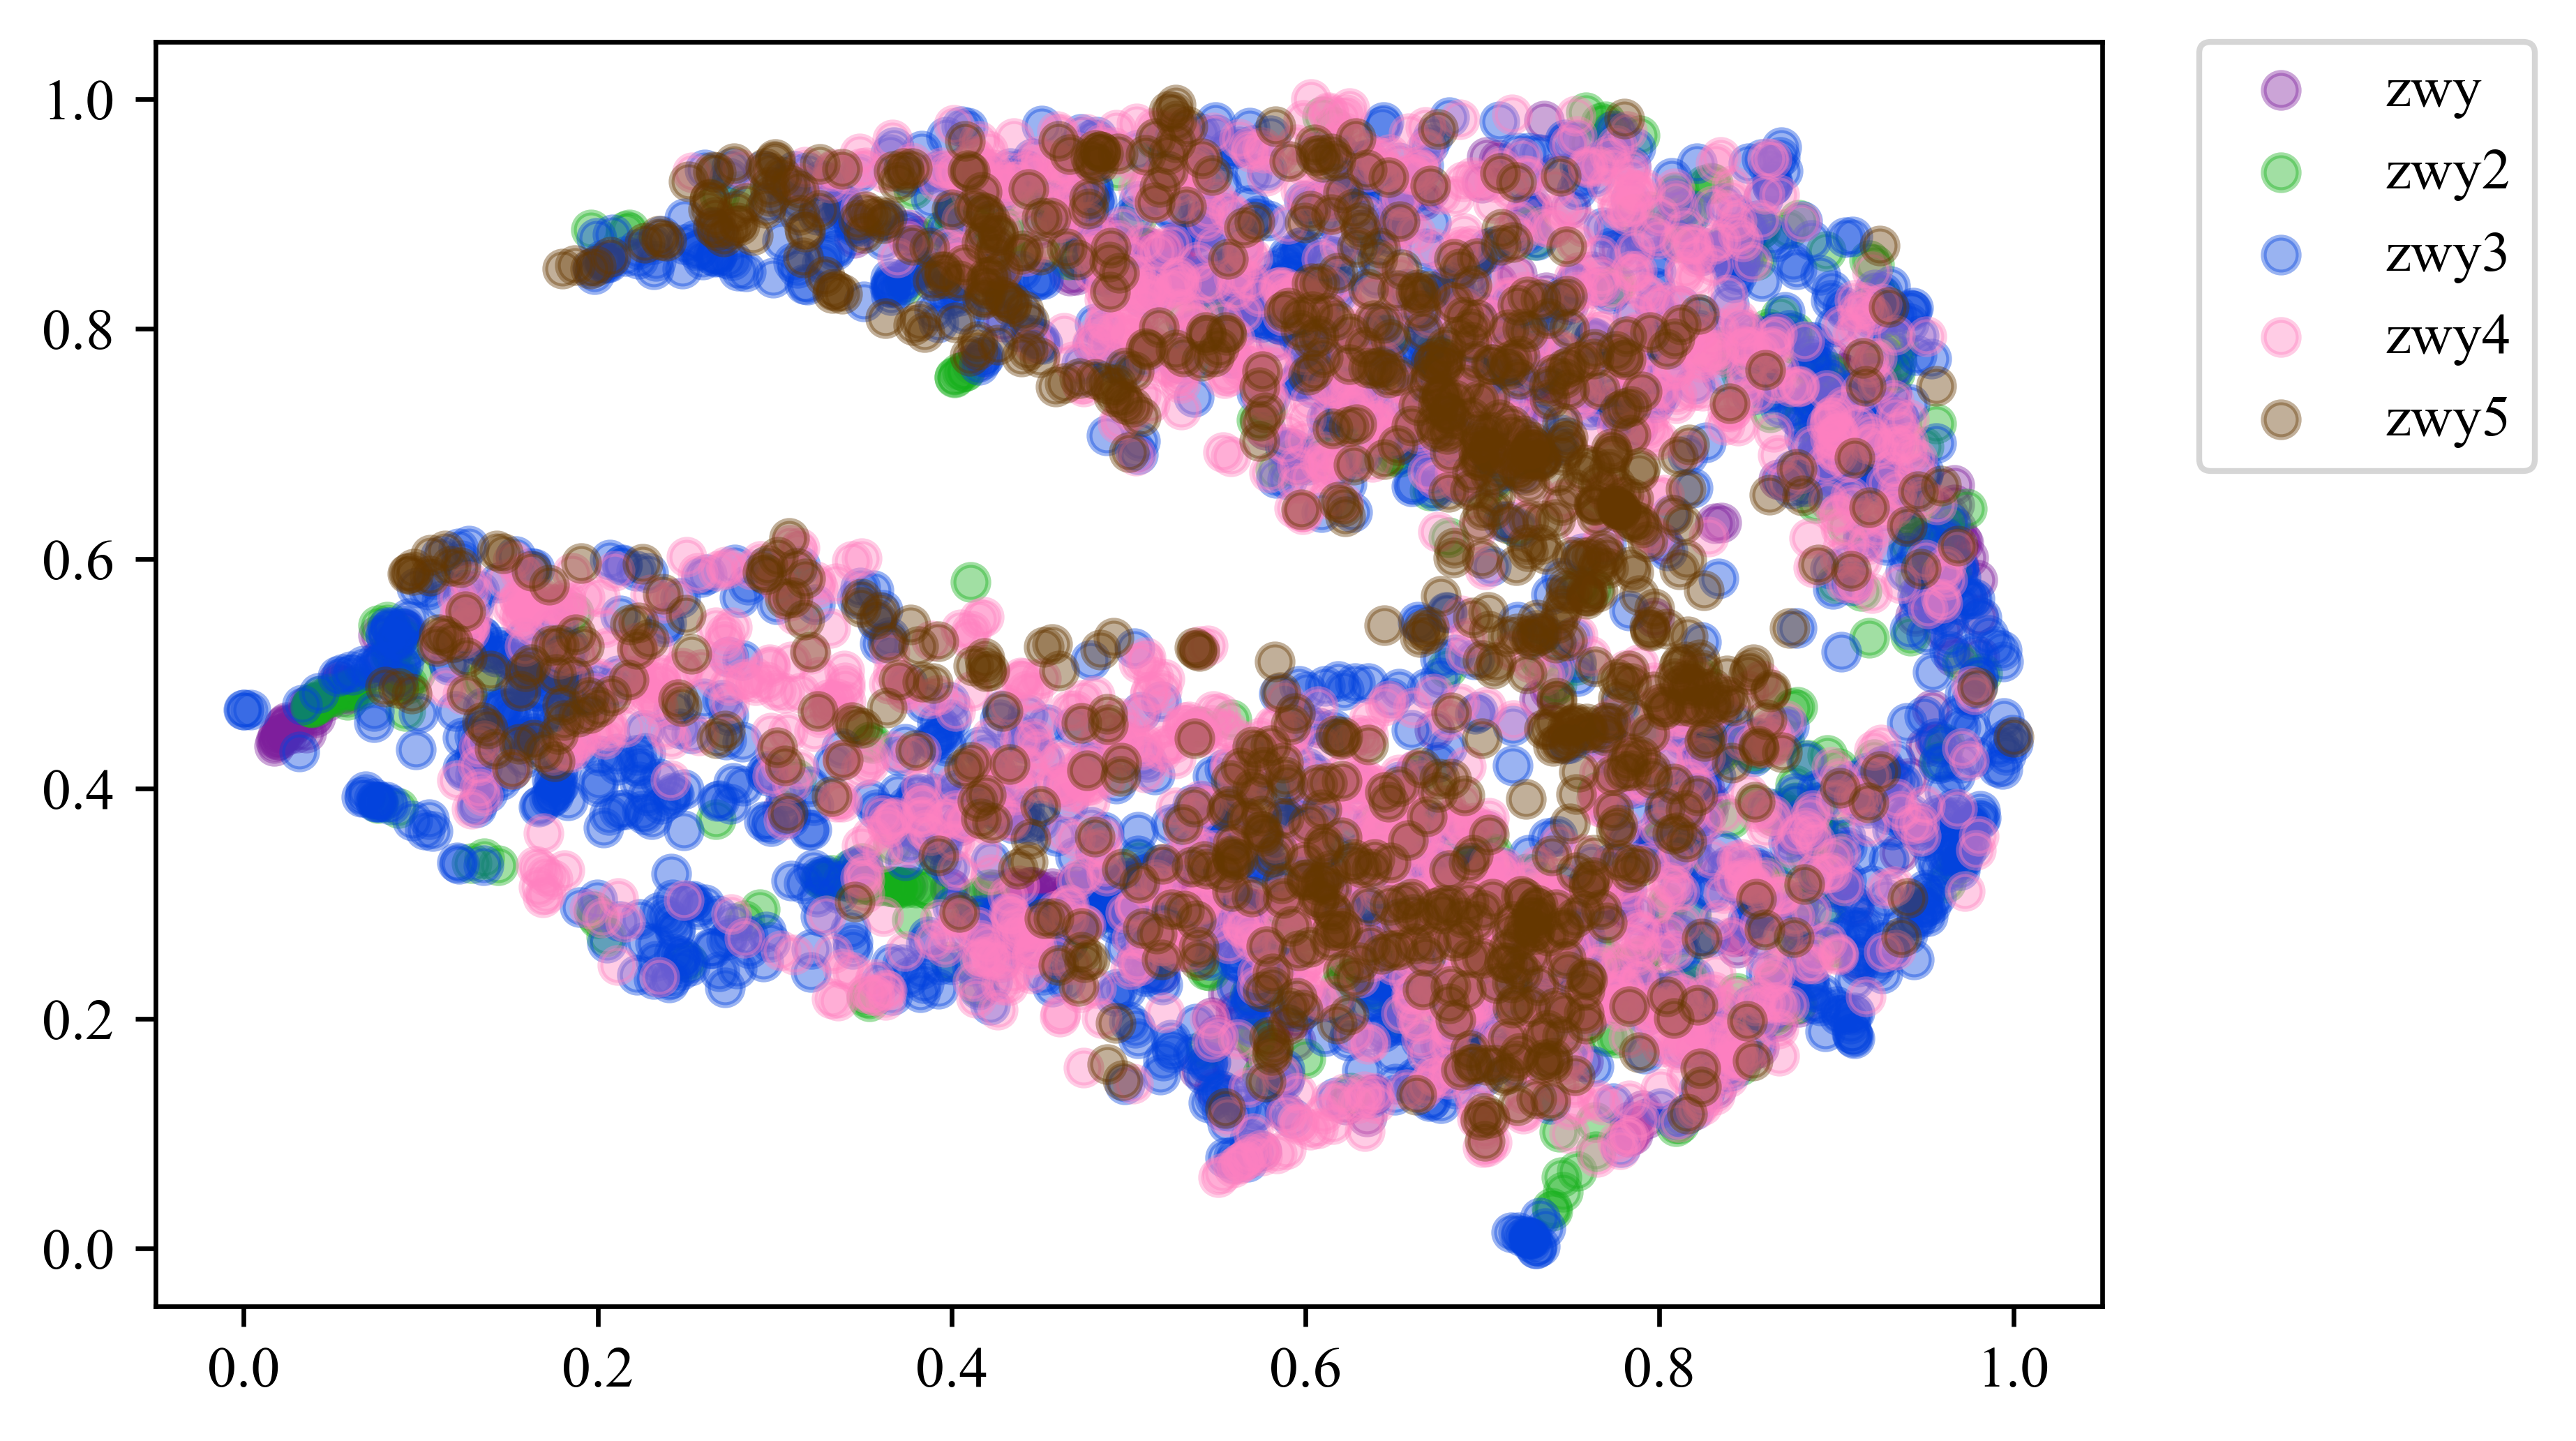

In [13]:
plt.figure(dpi=600)
plt.rc('font',family='Times New Roman')
# colors = ['r'] * 5 + ['g'] * 4 + ['b'] * 2 + ['y'] * 2 + ['c'] * 3 + ['m'] * 2
colors = ['#7e1e9c', '#15b01a', '#0343df', '#ff81c0', '#653700', '#e50000', \
    '#95d0fc', '#029386', '#f97306', '#96f97b', '#c20078', '#ffff14', \
    '#661aee', '#c5c9c7', '#94b21c', '#ff7855', '#ba6873', '#b96902']
pre_size = 0
for idx, (key, value) in enumerate(rep_dict.items()):
    size = value.shape[0]
    plt.scatter(X_embed[pre_size: pre_size+size, 0], X_embed[pre_size: pre_size+size, 2], c=colors[idx], alpha = 0.4, label=key)
    pre_size += size
# plt.scatter(X_embed[18:24, 0], X_embed[18:24, 1], c='g', alpha = 0.2, label = "xcxp")
# plt.scatter(X_embed[22:24, 0], X_embed[22:24, 1], c='g', alpha = 0.2)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.show()